In [1]:
import pandas as pd
import sqlite3
import json
import os
from tqdm import tqdm

In [2]:
MXM_PATH = "/kaggle/input/musicxmatch-dataset/mxm_dataset_train.txt"
TRACKS_PATH = "/kaggle/input/million-song-dataset-spotify-lastfm/Music Info.csv"
LASTFM_DB = "/kaggle/input/lastfm/lastfm_similars.db"
OUTPUT_DIR = "/kaggle/working/output"
SIMILARITY_THRESHOLD = 0.6

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
with open(MXM_PATH, 'r', encoding='utf-8') as f:
    for _ in range(20):
        print(f.readline().strip())

# TRAINING SET
# MusiXmatch dataset, the official lyrics dataset
# of the Million Song Dataset
#    file created on Tue Mar 29 04:28:44 2011
#    contact: T. Bertin-Mahieux (Columbia University)
#             tb2332@columbia.edu
#    also: http://labrosa.ee.columbia.edu/millionsong/musixmatch
#          http://www.musixmatch.com
# FORMAT:
#     #   - comment, to ignore
#     %   - list of top words, comma-separated
#         - normal line, contains track_id, mxm track id,
#           then word count for each of the top words, comma-separated
#           word count is in sparse format -> ...,<word idx>:<cnt>,...
#           <word idx> starts at 1 (not zero!)
# All our work is done using UTF-8 encoding.
# enjoy!
%i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,de,there,go,up,oh,la,one,they,out,down,get,she,was,see,if,got,never,from,he,feel,want,let,make,way,say,take,would,as,ca

In [4]:
df_tracks = pd.read_csv(TRACKS_PATH)
df_tracks.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


In [5]:
import sqlite3

LASTFM_DB = "/kaggle/input/lastfm/lastfm_similars.db"
conn = sqlite3.connect(LASTFM_DB)

# View available tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", cursor.fetchall())


Tables: [('similars_src',), ('similars_dest_tmp',), ('similars_dest',)]


In [7]:
import sqlite3
import pandas as pd

LASTFM_DB = "/kaggle/input/lastfm/lastfm_similars.db"
conn = sqlite3.connect(LASTFM_DB)

# Load from the final table
df_sim = pd.read_sql_query("SELECT * FROM similars_src", conn)
conn.close()

# Inspect
df_sim.head()


,tid,target
0,TRCCCYE12903CFF0E9,"TRHZRQH128F92F9AC2,0.498053,TRZQUEN12903CBFFBB..."
1,TRCCCPM12903CBEEE5,"TRNRRXT12903CFAD5A,1,TRWVNWV12903CBEEE7,0.5238..."
2,TRCCCFH12903CEBC70,"TRRGGCN128F92E3579,0.646036,TRTVJGV128F424A147..."
3,TRCCCJT128F429FFF6,"TRZSKOT128F429FFFC,1,TRYVKKD12903CEB9E2,1,TRVC..."
4,TRCCCBJ128F4286E6F,"TRHUKZN128F428B2BD,1,TRMMPCY128F4253A20,0.9906..."


In [8]:
print("Loading musiXmatch lyrics...")

with open(MXM_PATH, encoding='utf-8') as f:
    lines = f.readlines()

# Parse top words
top_words = []
for line in lines:
    if line.startswith('%'):
        top_words = line[1:].strip().split(',')
        break

# Parse each song's BOW vector
lyrics_dict = {}
for line in lines:
    if line.startswith('#') or line.startswith('%'):
        continue
    parts = line.strip().split(',')
    track_id = parts[0]
    word_pairs = parts[2:]

    bow = {}
    for wp in word_pairs:
        if ':' in wp:
            idx, count = wp.split(':')
            idx = int(idx) - 1
            if idx < len(top_words):
                bow[top_words[idx]] = int(count)
    lyrics_dict[track_id] = bow

print(f"Loaded lyrics for {len(lyrics_dict)} tracks.")

Loading musiXmatch lyrics...
Loaded lyrics for 210519 tracks.


In [9]:
import sqlite3
import pandas as pd

# Expand the 'target' field into multiple rows
expanded_rows = []

for idx, row in df_sim.iterrows():
    src_id = row['tid']
    target_str = row['target']
    if pd.isna(target_str):
        continue
    
    parts = target_str.split(',')
    for i in range(0, len(parts)-1, 2):  # every (track_id, score) pair
        try:
            tgt_id = parts[i]
            score = float(parts[i+1])
            expanded_rows.append((src_id, tgt_id, score))
        except:
            continue

# Create DataFrame
df_sim = pd.DataFrame(expanded_rows, columns=['track_id1', 'track_id2', 'score'])

print(f"✅ Expanded to {len(df_sim)} strong similarity pairs.")
df_sim.head()


✅ Expanded to 56506688 strong similarity pairs.


,track_id1,track_id2,score
0,TRCCCYE12903CFF0E9,TRHZRQH128F92F9AC2,0.498053
1,TRCCCYE12903CFF0E9,TRZQUEN12903CBFFBB,0.498053
2,TRCCCYE12903CFF0E9,TRIRQTJ12903CAC5C4,0.498053
3,TRCCCYE12903CFF0E9,TRNLGXS12903CBFF8E,0.498053
4,TRCCCYE12903CFF0E9,TRXAOIV12903CAC665,0.498053


In [10]:
import gc
gc.collect()

0

In [11]:
import random
import pandas as pd
from tqdm import tqdm

positive_pairs = set(map(tuple, df_sim[['track_id1', 'track_id2']].values))

# Use the actual lyrics keys to ensure negative pairs have lyrics
track_ids = list(lyrics_dict.keys())

# Generate N random negatives
N = 50_000
import numpy as np
print("Starting now")
gc.collect()

def generate_negatives(num_neg, all_ids, positive_set):
    negs = set()
    while len(negs) < num_neg:
        t1 = np.random.choice(all_ids)
        t2 = np.random.choice(all_ids)
        if t1 != t2 and (t1, t2) not in positive_set and (t2, t1) not in positive_set:
            negs.add((t1, t2))
    return list(negs)

neg_pairs = generate_negatives(N, track_ids, positive_pairs)
df_neg = pd.DataFrame(neg_pairs, columns=['track_id1', 'track_id2'])
df_neg['score'] = 0.0

Starting now


In [12]:
import gc
gc.collect()

0

In [13]:
import csv
import gc
from tqdm import tqdm

def bow_to_text(bow):
    return ' '.join([word for word, count in bow.items() for _ in range(count)])

OUTPUT_PATH = "/kaggle/working/pairs.csv"

valid_ids = set(lyrics_dict.keys())

# Filter positives too
df_sim_filtered = df_sim[
    df_sim['track_id1'].isin(valid_ids) &
    df_sim['track_id2'].isin(valid_ids)
]

df_neg_filtered = df_neg[
    df_neg['track_id1'].isin(valid_ids) &
    df_neg['track_id2'].isin(valid_ids)
]

# Now merge
all_pairs = pd.concat([
    df_sim_filtered[['track_id1', 'track_id2', 'score']],
    df_neg_filtered[['track_id1', 'track_id2', 'score']]
], ignore_index=True)

batch_size = 50_000
num_batches = len(all_pairs) // batch_size + 1

# Write header
with open(OUTPUT_PATH, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['lyrics1', 'lyrics2', 'score'])

# Process in chunks
print(f"Streaming {len(all_pairs):,} pairs in {num_batches} batches...")
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(all_pairs))
    chunk = all_pairs.iloc[start:end].copy()

    chunk['lyrics1'] = chunk['track_id1'].map(lambda tid: bow_to_text(lyrics_dict.get(tid, {})))
    chunk['lyrics2'] = chunk['track_id2'].map(lambda tid: bow_to_text(lyrics_dict.get(tid, {})))

    # Drop empty ones
    chunk = chunk[(chunk['lyrics1'].str.len() > 0) & (chunk['lyrics2'].str.len() > 0)]
    with open(OUTPUT_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for _, row in chunk.iterrows():
            writer.writerow([row['lyrics1'], row['lyrics2'], row['score']])

    print(f"Batch {i+1}/{num_batches}: saved {len(chunk)} rows")
    del chunk
    gc.collect()

print("Done! Final CSV saved to:", OUTPUT_PATH)

Streaming 7,685,234 pairs in 154 batches...
Batch 1/154: saved 50000 rows
Batch 2/154: saved 50000 rows
Batch 3/154: saved 50000 rows
Batch 4/154: saved 50000 rows
Batch 5/154: saved 50000 rows
Batch 6/154: saved 50000 rows
Batch 7/154: saved 50000 rows
Batch 8/154: saved 50000 rows
Batch 9/154: saved 50000 rows
Batch 10/154: saved 50000 rows
Batch 11/154: saved 50000 rows
Batch 12/154: saved 50000 rows
Batch 13/154: saved 50000 rows
Batch 14/154: saved 50000 rows
Batch 15/154: saved 50000 rows
Batch 16/154: saved 50000 rows
Batch 17/154: saved 50000 rows
Batch 18/154: saved 50000 rows
Batch 19/154: saved 50000 rows
Batch 20/154: saved 50000 rows


KeyboardInterrupt: 

In [2]:
!pip install gdown

In [3]:
!gdown --id 1YL84jf7tKz9Ipke8-f_HivvoJXdLoklj

/jet/home/langevin/.conda/envs/project/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YL84jf7tKz9Ipke8-f_HivvoJXdLoklj
From (redirected): https://drive.google.com/uc?id=1YL84jf7tKz9Ipke8-f_HivvoJXdLoklj&confirm=t&uuid=bd6342d2-709d-4c03-85e3-0c1443663f02
To: /ocean/projects/cis250019p/langevin/pairs (4).csv
100%|██████████████████████████████████████| 2.04G/2.04G [02:25<00:00, 14.0MB/s]


# Model

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [12]:
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LEN = 300
DROPOUT = 0.5
THRESHOLD = 0.05
GLOVE_PATH = "glove.6B.100d.txt"

In [4]:
df = pd.read_csv("/ocean/projects/cis250019p/langevin/pairs (4).csv") 
df = df.dropna()
df = df[df['lyrics1'].str.len() > 0]
df = df[df['lyrics2'].str.len() > 0]
df = df[df['score'].between(0, 1)]

# Convert score to binary label
df['label'] = (df['score'] >= THRESHOLD).astype(int)

print(df['label'].value_counts())  # class balance
df.head()

label
1    615330
0    405140
Name: count, dtype: int64


,lyrics1,lyrics2,score,label
0,i i i i i i the the the the the you you you to...,i i the the to to to and it it not in are are ...,1.000000,1
1,i i i i i i the the the the the you you you to...,i i i i i i i the the the you you you you you ...,0.671106,1
2,i i i i i i the the the the the you you you to...,i i i i i i i i i i the the the the the the th...,0.054148,1
3,i i i i i i the the the the the you you you to...,i i i i i i i i i i the the the the the the yo...,0.051151,1
4,i i i i i i the the the the the you you you to...,i i i i i i i i i i i i i i i i i i i you you ...,0.003043,0


In [5]:
all_lyrics = pd.concat([df['lyrics1'], df['lyrics2']])
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(all_lyrics)

seq1 = tokenizer.texts_to_sequences(df['lyrics1'])
seq2 = tokenizer.texts_to_sequences(df['lyrics2'])

x1 = pad_sequences(seq1, maxlen=MAX_SEQ_LEN)
x2 = pad_sequences(seq2, maxlen=MAX_SEQ_LEN)
y = df['label'].astype(np.float32).values

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

In [6]:
print("Loading GloVe...")
embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("GloVe loaded.")

# Build embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Loading GloVe...
GloVe loaded.
Embedding matrix shape: (4999, 100)


In [7]:
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(
    x1, x2, y, test_size=0.2, random_state=42)

In [8]:
input1 = Input(shape=(MAX_SEQ_LEN,))
input2 = Input(shape=(MAX_SEQ_LEN,))

embedding = Embedding(input_dim=4999,
                      output_dim=100,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQ_LEN,
                      trainable=True)

x1_embed = embedding(input1)
x2_embed = embedding(input2)

x1_lstm = Bidirectional(LSTM(64))(x1_embed)
x2_lstm = Bidirectional(LSTM(64))(x2_embed)

merged = Concatenate()([x1_lstm, x2_lstm])
merged = Dense(128)(merged)
merged = BatchNormalization()(merged)
merged = Activation("relu")(merged)
merged = Dropout(DROPOUT)(merged)

merged = Dense(64, activation="relu")(merged)
output = Dense(1, activation="sigmoid")(merged)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745158992.259529      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745158992.260237      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 300, 100)       │        499,900 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         84,480 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         84,480 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 710,589 (2.71 MB)

 Trainable params: 710,333 (2.71 MB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
import gc
gc.collect()

2326

In [13]:
history = model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    batch_size=256,
    epochs=20
)

Epoch 1/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 293s 92ms/step - accuracy: 0.6364 - loss: 0.6365 - val_accuracy: 0.7248 - val_loss: 0.5435
Epoch 2/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 295s 92ms/step - accuracy: 0.7439 - loss: 0.5172 - val_accuracy: 0.7612 - val_loss: 0.4925
Epoch 3/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 295s 93ms/step - accuracy: 0.7780 - loss: 0.4669 - val_accuracy: 0.7771 - val_loss: 0.4698
Epoch 4/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 295s 93ms/step - accuracy: 0.8003 - loss: 0.4316 - val_accuracy: 0.7849 - val_loss: 0.4569
Epoch 5/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 295s 93ms/step - accuracy: 0.8131 - loss: 0.4107 - val_accuracy: 0.7908 - val_loss: 0.4473
Epoch 6/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 296s 93ms/step - accuracy: 0.8233 - loss: 0.3934 - val_accuracy: 0.7962 - val_loss: 0.4406
Epoch 7/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 296s 93ms/step - accuracy: 0.8302 - loss: 0.3809 - val_accuracy: 0.7983 - val_loss: 0.4365
Epoch 8/20
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 296s 93ms/step - accuracy: 

In [14]:
val_preds = model.predict([x1_val, x2_val])
val_preds_labels = (val_preds.flatten() >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, val_preds_labels))
print("\nClassification Report:\n", classification_report(y_val, val_preds_labels))

6378/6378 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step
Accuracy: 0.8053004987897734

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.71      0.74     80745
         1.0       0.82      0.87      0.84    123349

    accuracy                           0.81    204094
   macro avg       0.80      0.79      0.79    204094
weighted avg       0.80      0.81      0.80    204094



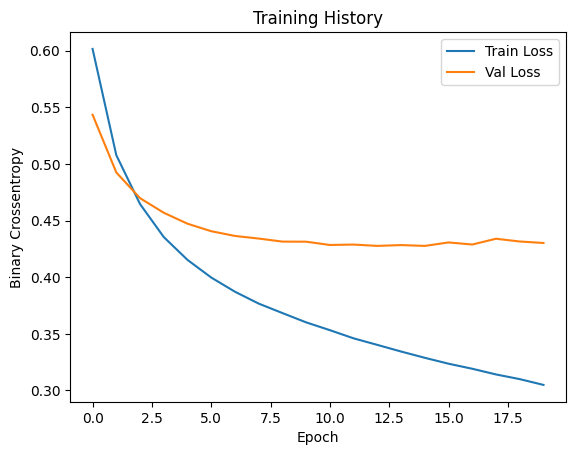

In [15]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.show()

# Regression Model

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Concatenate, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer

2025-04-22 20:45:27.648617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 20:45:28.918885: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Config
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_SEQ_LEN = 300
DROPOUT = 0.3
GLOVE_PATH = "glove.6B.100d.txt"

In [3]:
df = pd.read_csv("/ocean/projects/cis250019p/langevin/pairs (4).csv")
print(df.info())
df.columns = ['lyrics1', 'lyrics2', 'score']
print(df.head())
df = df.dropna()
df = df[df['lyrics1'].str.len() > 0]
df = df[df['lyrics2'].str.len() > 0]
df = df[df['score'].between(0, 1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020471 entries, 0 to 1020470
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   lyrics1  1020471 non-null  object 
 1   lyrics2  1020471 non-null  object 
 2   score    1020471 non-null  float64
dtypes: float64(1), object(2)
memory usage: 23.4+ MB
None
                                             lyrics1  \
0  i i i i i i the the the the the you you you to...   
1  i i i i i i the the the the the you you you to...   
2  i i i i i i the the the the the you you you to...   
3  i i i i i i the the the the the you you you to...   
4  i i i i i i the the the the the you you you to...   

                                             lyrics2     score  
0  i i the the to to to and it it not in are are ...  1.000000  
1  i i i i i i i the the the you you you you you ...  0.671106  
2  i i i i i i i i i i the the the the the the th...  0.054148  
3  i i i i i i i i i i the the th

In [4]:
all_lyrics = pd.concat([df['lyrics1'], df['lyrics2']])
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(all_lyrics)

seq1 = tokenizer.texts_to_sequences(df['lyrics1'])
seq2 = tokenizer.texts_to_sequences(df['lyrics2'])

x1 = pad_sequences(seq1, maxlen=MAX_SEQ_LEN)
x2 = pad_sequences(seq2, maxlen=MAX_SEQ_LEN)
y = df['score'].astype(np.float32).values

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

In [5]:
embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Build embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (4999, 100)


In [6]:
x1_trainval, x1_test, x2_trainval, x2_test, y_trainval, y_test = train_test_split(
    x1, x2, y, test_size=0.2, random_state=42
)

# Step 2: Split the train+val set into train and validation sets (80% train, 20% validation)
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(
    x1_trainval, x2_trainval, y_trainval, test_size=0.2, random_state=42
)

In [7]:
class LyricsDataGenerator(Sequence):
    def __init__(self, x1, x2, y, batch_size=256, shuffle=True):
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        return (self.x1[inds], self.x2[inds]), self.y[inds]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = LyricsDataGenerator(x1_train, x2_train, y_train)
val_generator = LyricsDataGenerator(x1_val, x2_val, y_val, shuffle=False)
test_generator = LyricsDataGenerator(x1_test, x2_test, y_test, shuffle=False)

In [8]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.layers import Subtract, Multiply

def build_model(embedding_matrix):
    vocab_size, embedding_dim = embedding_matrix.shape

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix.astype(np.float32)],
        trainable=True
    )

    def encoded_branch(input_seq):
        x = embedding_layer(input_seq)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = Bidirectional(LSTM(128, return_sequences=False))(x)
        return x

    input1 = Input(shape=(x1.shape[1],))
    input2 = Input(shape=(x2.shape[1],))
    encoded1 = encoded_branch(input1)
    encoded2 = encoded_branch(input2)

    diff = Subtract()([encoded1, encoded2])
    prod = Multiply()([encoded1, encoded2])
    merged = Concatenate()([encoded1, encoded2, diff, prod])
    x = Dense(128, kernel_regularizer=l2(1e-4))(merged)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    output = Dense(1)(x)

    model = Model(inputs=[input1, input2], outputs=output)
    return model

model = build_model(embedding_matrix)
model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

2025-04-22 20:51:41.479827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 20:51:41.657842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [9]:
import gc 
gc.collect()

26135

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "best_model.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_mae',       # or 'val_mae' if you're tracking that
    save_best_only=True,
    save_weights_only=False,  # saves full model (structure + weights)
    mode='min',
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        checkpoint,
    ]
)

Epoch 1/10


2025-04-22 20:51:57.333369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


2552/2552 [==============================] - ETA: 0s - loss: 0.0572 - mae: 0.1035
Epoch 1: val_mae improved from inf to 0.07623, saving model to best_model.keras
2552/2552 [==============================] - 753s 292ms/step - loss: 0.0572 - mae: 0.1035 - val_loss: 0.0370 - val_mae: 0.0762
Epoch 2/10
2552/2552 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.0846
Epoch 2: val_mae did not improve from 0.07623
2552/2552 [==============================] - 743s 291ms/step - loss: 0.0331 - mae: 0.0846 - val_loss: 0.0293 - val_mae: 0.0900
Epoch 3/10
2552/2552 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.0779
Epoch 3: val_mae improved from 0.07623 to 0.07427, saving model to best_model.keras
2552/2552 [==============================] - 743s 291ms/step - loss: 0.0270 - mae: 0.0779 - val_loss: 0.0251 - val_mae: 0.0743
Epoch 4/10
2552/2552 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.0753
Epoch 4: val_mae did not improve from 0.07427
25

In [11]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")

In [13]:
from sklearn.metrics import precision_recall_curve, auc

preds = best_model.predict(test_generator).flatten()

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds)

print(f"MAE on test data: {mae:.4f}")
print(f"RMSE on test data: {rmse:.4f}")

798/798 [==============================] - 82s 103ms/step
MAE on test data: 0.0678
RMSE on test data: 0.0238


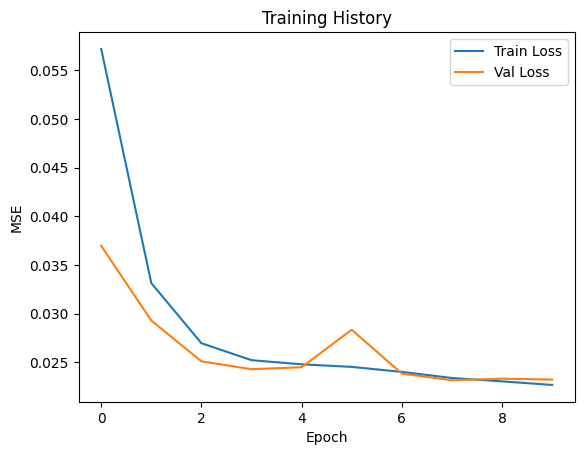

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training History')
plt.legend()
plt.show()